In [1]:
import pandas as pd 
import re
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import html
import preprocessor as pp
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from nltk.probability import FreqDist

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manasip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/manasip/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv("df_filteredfinal.csv", lineterminator='\n', encoding='utf-8')

In [4]:
df.head()

,Tweet Id,Text,Username,Noisy,Location,Name,User_Id,Year\r
0,8.150000e+17,Women Deserve the Truth About Down Syndrome an...,LifeNewsToo,abortion,USA,LifeNews,7.455226e+07,2016
1,8.140000e+17,@Cagsil @ivotedhillary \nHow about Abortion yo...,itzMeiVo,abortion,"Indianapolis, IN USA",MAGAFAM,8.090000e+17,2016
2,8.130000e+17,"@SenSanders. I hate abortion, but same people ...",Batt6C,abortion,United States,Will 2017,7.870000e+17,2016
3,8.120000e+17,If only pro-life activists spent as much time ...,danielle_browni,abortion,"Boulder, CO",🌻 danielle,2.830944e+09,2016
4,8.110000e+17,@TIME @motto I wish her mom had an abortion.,DioxaV,abortion,"New York, NY",Dioxazine Violet,2.204231e+09,2016


In [5]:
#Rename columns
df.rename(columns={"Tweet Id": "id", "Text": "tweet", "Username": "user", "Noisy":"noisy"}, \
                   inplace=True)

In [7]:
##Check duplicate tweets
print(df.id.nunique(), df.shape[0])

174389 174389


--------------Descriptive stats---------------------

In [8]:
df['hashtags'] = df.tweet.apply(lambda x: re.findall(r"#(\w+)", x)) 

In [9]:
### Get top 15 hashtags

In [10]:
hashtag_series = df.hashtags

In [11]:
hashtag_series = hashtag_series.apply(pd.Series).stack().reset_index(drop=True)

In [12]:
hashtag_series = hashtag_series.str.lower()

In [13]:
df_hashtag = hashtag_series.value_counts().to_frame().rename(columns={0: "Count"})

In [14]:
df_hashtag[:15]

,Count
prochoice,45831
prolife,45609
abortion,14748
uniteblue,11140
feminism,7396
plannedparenthood,5869
pjnet,4086
unbornlivesmatter,3895
tcot,2551
maga,2081


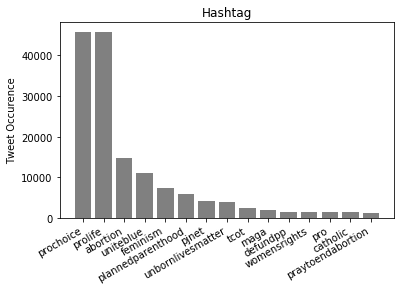

In [15]:
fig, ax = plt.subplots()

ax.bar(df_hashtag[:15].index, df_hashtag[:15].Count, \
       align="center", \
      color="grey")

plt.ylabel('Tweet Occurence')
plt.title('Hashtag')
fig.autofmt_xdate()

plt.show()

In [16]:
df.user.nunique()

62100

In [17]:
df.user.value_counts().mean()

2.808196457326892

In [18]:
df.user.value_counts().std()

47.67661284152905

----------Pre-processing Data-------------

In [19]:
df["clean_tweet"] = df.tweet

In [20]:
#Step 1: Decode html escape characters: &amp &quote etc
df.clean_tweet = df.clean_tweet.apply(lambda x: re.sub(r'&[a-z]+;', '', x))

In [21]:
#Sanity check
df['check'] = df.clean_tweet.str.contains("&", case=False, na=False).astype(int) # Checked for &gt, &amp &#62 &quote
print(sum(df.check))

0


In [22]:
#Step 2: Remove @mentions
df.clean_tweet = df.clean_tweet.apply(lambda x: re.sub('@[^\s]+','',x))
df.clean_tweet = df.clean_tweet.apply(lambda x: re.sub('@[^\w]+','',x))
df.clean_tweet = df.clean_tweet.apply(lambda x: re.sub('@','',x))

In [23]:
#Sanity check
df['check'] = df.clean_tweet.str.contains("@", case=False, na=False).astype(int) 
print(sum(df.check))

0


In [24]:
#Step 3 Remove \n \t \r
df.clean_tweet = df.clean_tweet.apply(lambda x: x.replace('\n', '').replace('\t', '').replace('\r', ''))

In [25]:
#Sanity check
df['check'] = df.clean_tweet.str.contains("\n", case=False, na=False).astype(int) 
print('n', sum(df.check))

df['check'] = df.clean_tweet.str.contains("\t", case=False, na=False).astype(int) 
print('t', sum(df.check))

df['check'] = df.clean_tweet.str.contains("\r", case=False, na=False).astype(int) 
print('r', sum(df.check))

n 0
t 0
r 0


In [26]:
#Step 4: Tweet-preprocessor to remove, urls, emojis, hashtags, reserved words, mentions (if any), smileys
df.clean_tweet = df.clean_tweet.apply(lambda x: pp.clean(x))

In [27]:
#Sanity check
df['check'] = df.clean_tweet.str.contains("#", case=False, na=False).astype(int) 
print("check #",sum(df.check))
df['check'] = df.clean_tweet.str.contains("http", case=False, na=False).astype(int) 
print("check http",sum(df.check))
df['check'] = df.clean_tweet.str.contains("http", case=False, na=False).astype(int) 
print("check www",sum(df.check))

check # 0
check http 6
check www 6


--------Ignore 6------------

In [28]:
#Step 5: Remove Placeholders
df.clean_tweet = df.clean_tweet.apply(lambda x: re.sub(r'{link}', '', x))
df.clean_tweet = df.clean_tweet.apply(lambda x: re.sub(r"\[video\]", '', x))

In [29]:
#Sanity check
df['check'] = df.clean_tweet.str.contains("{link}", case=False, na=False).astype(int) 
print("check link",sum(df.check))
df['check'] = df.clean_tweet.str.contains("\[video\]", case=False, na=False).astype(int) 
print("check video",sum(df.check))

check link 0
check video 35


-------Ignore 35-------------

In [30]:
#Step 6: Remove punctuations, digits
#Create helper function
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

def remove_digits(text):
    for digit in string.digits:
        text = text.replace(digit, '')
    return text

df.clean_tweet = df.clean_tweet.apply(remove_punctuations)

df.clean_tweet = df.clean_tweet.apply(remove_digits)

In [31]:
#Sanity check
df['check'] = df.clean_tweet.str.contains("\!", case=False, na=False).astype(int)
print("check !",sum(df.check))
df['check'] = df.clean_tweet.str.contains("\?", case=False, na=False).astype(int)
print("check ?",sum(df.check))
df['check'] = df.clean_tweet.str.contains("\.", case=False, na=False).astype(int)
print("check .",sum(df.check))

df['check'] = df.clean_tweet.str.contains("1", case=False, na=False).astype(int)
print("check 1",sum(df.check))

check ! 0
check ? 0
check . 0
check 1 0


In [32]:
#Step 7 Lowercase before tokenization
df.clean_tweet = df.clean_tweet.str.lower()

In [33]:
#Step 8 Tokenization
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

In [34]:
df["tok_tweet"] = df.clean_tweet.apply(lambda x: tknzr.tokenize(x))

In [35]:
#Step 9 Remove stopwords 
#Create helper function

stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

df.tok_tweet = df.tok_tweet.apply(lambda x: remove_stopwords(x))

In [36]:
#Step 10 Lemmatization
#Create helper function

lem = nltk.WordNetLemmatizer()

def lemmat(text):
    text = [lem.lemmatize(word) for word in text]
    return text

df.tok_tweet = df.tok_tweet.apply(lambda x: lemmat(x))

-------Tweet word distribution--------

In [37]:
#Create a list of all words
all_words = [word for tokens in df.tok_tweet for word in tokens]

In [38]:
#Create a list of tweet length
tweet_lengths = [len(tokens) for tokens in df.tok_tweet]

In [39]:
vocab = sorted(list(set(all_words)))

print('{} tokens total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(tweet_lengths)))

1857531 tokens total, with a vocabulary size of 66269
Max tweet length is 40


In [40]:
#Average word size
word_length = []
for word in all_words:
    word_length.append(len(word))

In [41]:
print('average word size is {}'.format( sum(word_length) / len(word_length)))

average word size is 5.875722666270442


/Users/manasip/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


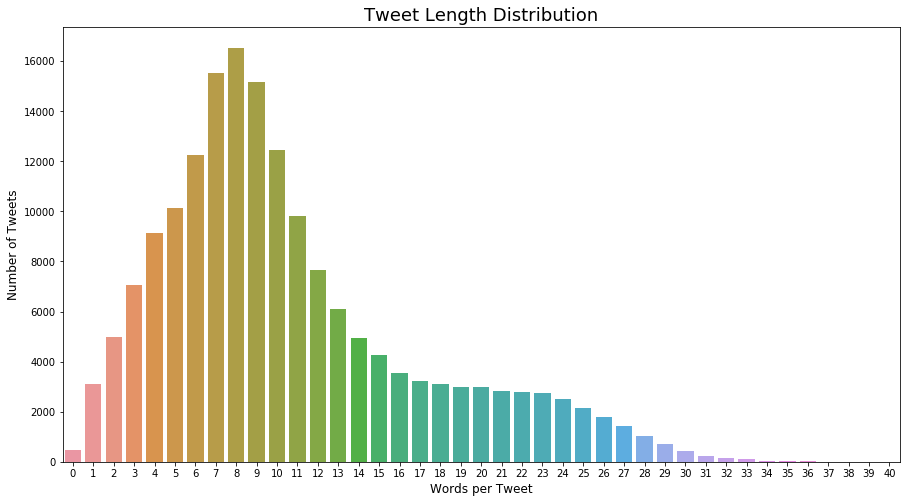

In [42]:
#Plotting tweet length distribution
plt.figure(figsize = (15,8))
sns.countplot(tweet_lengths)
plt.title('Tweet Length Distribution', fontsize = 18)
plt.xlabel('Words per Tweet', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize = 12)
plt.show()

In [43]:
#Removing all tweets with less than 3 words
tokens3 = df[df.tok_tweet.apply(lambda x: len(x) <= 3)].index

In [44]:
df.drop(tokens3, inplace = True)
df.reset_index(inplace=True)

In [45]:
all_words = [word for tokens in df.tok_tweet for word in tokens]
tweet_lengths = [len(tokens) for tokens in df.tok_tweet]
vocab = sorted(list(set(all_words)))

print('{} tokens total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(tweet_lengths)))

1823319 tokens total, with a vocabulary size of 65519
Max tweet length is 40


/Users/manasip/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


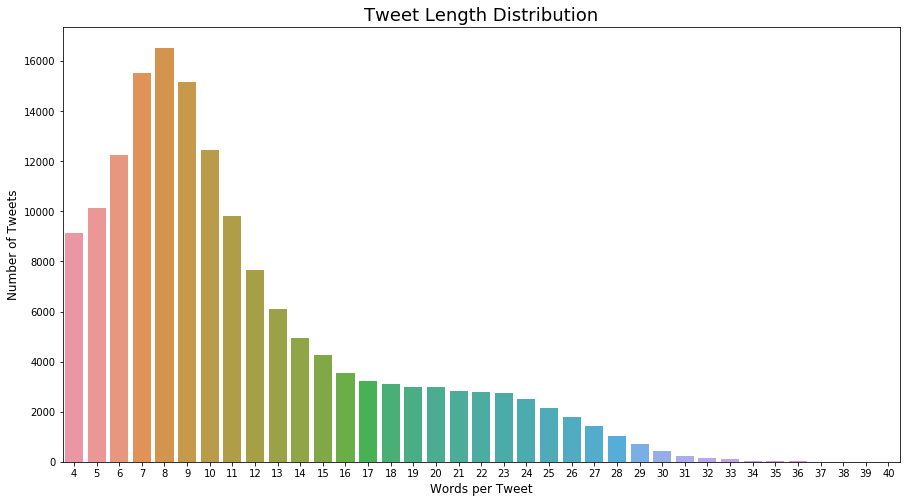

In [46]:
#Plotting tweet length distribution
plt.figure(figsize = (15,8))
sns.countplot(tweet_lengths)
plt.title('Tweet Length Distribution', fontsize = 18)
plt.xlabel('Words per Tweet', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize = 12)
plt.show()

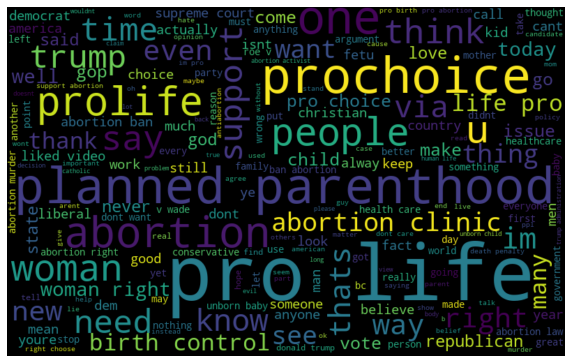

In [47]:
##Create word cloud
df["cloud"] = df.tok_tweet.apply(lambda x: ' '.join([str(elem) for elem in x]))
all_words2 = ' '.join([text for text in df.cloud])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words2)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()